[View in Colaboratory](https://colab.research.google.com/github/You-Your-Yu/machine-learning-assignment/blob/master/Shimosaka_mid_1515309.ipynb)

# Environmental Setting

In [3]:
!pip install matplotlib

# Dataset

## Dataset 1

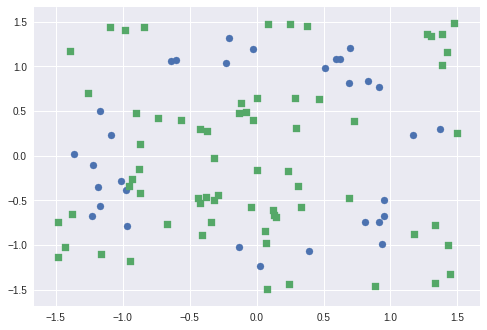

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# dataset 1
def create_dataset1(n=100, bias=False, sd=100):
    np.random.seed(sd)
    # x: n*2行列
    X = 3 * (np.random.rand(n, 2) - 0.5)
    # radius: n*1行列
    radius = X[:,0] ** 2 + X[:,1] ** 2
    # y: n*1行列
    y = np.logical_and((radius > (0.7 + 0.1 * np.random.randn(n, 1))).all(axis=0), (radius < (2.2 + 0.1 * np.random.randn(n, 1))).all(axis=0))
    y = 2 * y - 1
    if bias:
      X = np.c_[X, np.ones(len(X))]
    return X, y

### visualization ###
X, y = create_dataset1()
X_p = x[y == 1]
X_n = x[y == -1]
plt.scatter(X_p[:,0], X_p[:,1], marker='o')
plt.scatter(X_n[:,0], X_n[:,1], marker='s')
plt.show()

## Dataset 2

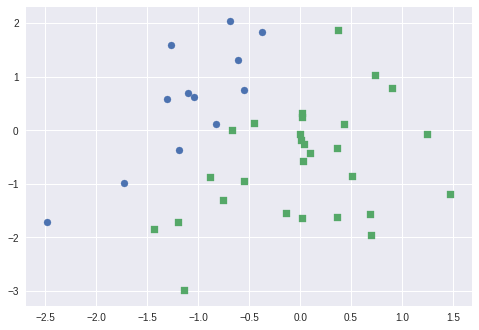

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def create_dataset2(n=40, bias=False,  sd=100):
    np.random.seed(sd)
    omega = np.random.randn(1, 1)
    noise = 0.8 * np.random.randn(n, 1)
    # x: n*2行列
    X = np.random.randn(n, 2)
    # y: n*1行列
    y = 2 * ((omega * X[:,0] + X[:,1] + noise) > 0).all(axis=0) -1
    if bias:
      X = np.c_[X, np.ones(len(X))]
    return X, y

### visualization ###
X, y = create_dataset2()
X_p = X[y == 1]
X_n = X[y == -1]
plt.scatter(X_p[:,0], X_p[:,1], marker='o')
plt.scatter(X_n[:,0], X_n[:,1], marker='s')
plt.show()

# Promlem 1

## Differentiation

In [0]:
# 微分
def differentiate(f, w, x, y, lm, h=0.01):
    I = np.eye(w.shape[0])
    return (f(w[:, np.newaxis] + h * I, x, y, lm) - f(w, x, y, lm)) / h


## Loss function

In [0]:
# 損失関数
def loss(w, x, y, lm):
    ret = np.log(1 + np.exp(-y * np.dot(x, w)))
    ret = np.sum(ret, axis=0) + lm * np.dot(w.T, w)
    return ret


In [0]:
X, y = create_dataset1()
w = np.random.rand(x.shape[1])
print('x:{}, y:{}, w:{}'.format(x.shape, y.shape, y.shape))
lm = 0.01
J = loss(w, x, y, lm)
dJ = differentiate(loss, w, x, y, lm)
print('J:{}'.format(J.shape))

# Problem 3

In [7]:
import numpy as np

# loss function
def loss(w, X, y, lm=0.1):
  tmp = 1 -  np.dot(y[:, np.newaxis]  * X, w)
  tmp = np.clip(tmp, a_min=0, a_max=np.inf)
  return np.sum(tmp, axis=0)

# negative dual lagrange function
def ndl(alpha, K, lm=0.1):
  return np.dot(np.dot(alpha.T, K), alpha) / 4 / lm - np.dot(alpha.T, np.ones(alpha.shape[0]))

# differntiation of negative dual lagrange function
def dndl(alpha, K, lm=0.1):
  return np.dot(K, alpha) / 2 / lm  - 1    

# differentiation of negative dual lagrange function by learning rate
def dndl_by_lr(lr, alpha, K, lm=0.1):
  dndl_curr = dndl(alpha, K, lm)
  return 2 * lr * np.dot(dndl_curr, dndl_curr) - 2 * np.dot(dndl_curr.T, np.dot(K, alpha))
  
# update alpha by using projected gradient
def update(prev, K, lm=0.1, lr_init=1, c=0.5, rho=0.5):
  lr = lr_init
  while True:
    curr = prev - lr * dndl(prev, K, lm)
    curr[curr < 0] = 0
    curr[1 < curr] = 1
    ndl_curr = ndl(curr, K, lm)
    ndl_prev = ndl(prev, K, lm)
    dndl_by_lr_prev = dndl_by_lr(0, prev, K, lm) 
    condition = (ndl_curr <= (ndl_prev + c * lr * dndl_by_lr_prev))
    #condition = (ndl_curr <= ndl_prev)
    if condition:
      #print(lr)
      break
    else:
      lr *= rho
      curr = prev
  return curr
  
  
### preparing dataset ###
n = 40
bias = True
train_X, train_y = create_dataset2(n, bias, sd=100)
train_K = np.diag(train_y).dot(train_X).dot(train_X.T).dot(np.diag(train_y))
test_X, test_y = create_dataset2(n, bias, sd=200)
test_K = np.diag(test_y).dot(test_X).dot(test_X.T).dot(np.diag(test_y))
print('train_X: {}, train_y: {}'.format(train_X.shape, train_y.shape))
print('train_K: {}'.format(train_K.shape))
print('test_X: {}, test_y: {}'.format(test_X.shape, test_y.shape))
print('test_K: {}'.format(test_K.shape))
print('\n')

### training ###
alpha = 0.5 * np.random.rand(train_X.shape[0]) + 0.5
lm = 0.01
lr_init = 1
fin = 0.0001
log = []
prev = alpha
log.append(alpha)
for i in range(1000):
  curr = update(prev, train_K, lm, lr_init)
  log.append(curr)
  if (np.linalg.norm(curr - prev) < fin).all():
    break
  prev = curr

### result ###
last = log[-1]
w = train_X.T.dot(np.diag(train_y)).dot(last)
print('total steps: {}'.format(len(log) - 1))
print('train_ndl: {:.4f}, train_loss: {:.4f}'.format(ndl(last, train_K, lm), loss(w, train_X, train_y, lm)))
print('test_ndl: {:.4f}, test_loss: {:.4f}'.format(ndl(last, test_K, lm), loss(w, test_X, test_y, lm)))
train_pred = (np.dot(train_X, w) >= 0) * 2 - 1
train_acc = np.sum(train_pred == train_y, axis=0) / len(train_y)
test_pred = (np.dot(test_X, w) >= 0) * 2 - 1
test_acc = np.sum(test_pred == test_y, axis=0) / len(test_y)
print('tarin_accracy: {:.4f}, test_accuracy: {:.4f}'.format(train_acc, test_acc))
print('\n')
'''
for i, item in enumerate(log):
  w_i = np.dot(train_y[np.newaxis, :] * train_X.T, item)
  l = loss(w_i, train_X, train_y, lm)
  print('step={}'.format(i))
  print('train_ndl: {:.4f}, train_loss: {:.4f}'.format(ndl(item, train_K, lm), loss(w_i, train_X, train_y, lm)))
  print('test_ndl: {:.4f}, test_loss: {:.4f}'.format(ndl(item, test_K, lm), loss(w_i, test_X, test_y, lm)))
  print(item)
 
'''
print('alpha: {}\nw: {}'.format(last, w))

train_X: (40, 3), train_y: (40,)
train_K: (40, 40)
test_X: (40, 3), test_y: (40,)
test_K: (40, 40)


total steps: 21
train_ndl: 3.8428, train_loss: 26.2325
test_ndl: 149.9635, test_loss: 23.2530
tarin_accracy: 0.9750, test_accuracy: 0.8750


alpha: [0.15457989 0.         0.14712885 0.         0.         0.
 0.72587111 0.         0.         0.17901703 0.         0.
 0.         0.         0.46837949 0.         0.         0.01020868
 0.         0.         0.         0.         0.         0.
 0.2921232  0.6077662  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.50491543 0.         0.         0.        ]
w: [-0.40101016  0.13441263 -0.31374175]


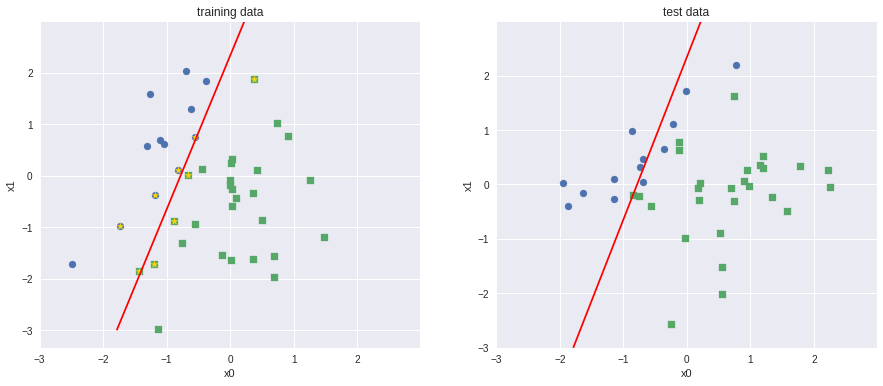

In [9]:
# visualization for train data
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(15, 6))

train_X_p = train_X[train_y == 1]
train_X_n = train_X[train_y == -1]
test_X_p = test_X[test_y == 1]
test_X_n = test_X[test_y == -1]

sv = train_X[last.astype(bool)]

x0range = np.arange(-3, 3, 0.01)
x1range = np.arange(-3, 3, 0.01)
X0, X1 = np.meshgrid(x0range, x1range)
Y = X0 * w[0] + X1 * w[1]
if bias:
  Y += w[2]
axL.set_title('training data')
axL.set_xlabel('x0')
axL.set_ylabel('x1')
axL.contour(X0, X1, Y, [0], colors='red')
axL.scatter(train_X_p[:,0], train_X_p[:,1], marker='o')
axL.scatter(train_X_n[:,0], train_X_n[:,1], marker='s')
axL.scatter(sv[:,0], sv[:,1], marker='*', color='gold')
axR.set_title('test data')
axR.set_xlabel('x0')
axR.set_ylabel('x1')
axR.contour(X0, X1, Y, [0], colors='red')
axR.scatter(test_X_p[:,0], test_X_p[:,1], marker='o')
axR.scatter(test_X_n[:,0], test_X_n[:,1], marker='s')
plt.show()